# Introduction

In this notebook, we will explore the use of matrix representations of graphs, and show how their are direct matrix parallels for some of the algorithms that we have investigated.

In [188]:
import networkx as nx
import matplotlib.pyplot as plt
import nxviz as nv
from custom.load_data import load_university_social_network
from matplotlib import animation

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For this notebook, we will specifically see the connection between matrix operations and pathfinding between nodes.

# Toy Example: Linear Chain

To start, let us use a simple four-node network, in which nodes are joined in a chain. Convince yourself that this is is a linear chain by running the cell below.

In [99]:
nodes = list(range(4))
G1 = nx.Graph()

G1.add_nodes_from(nodes)
G1.add_edges_from(zip(nodes, nodes[1:]))

## Graph Form

When visualized as circles and lines, the graph looks like this:

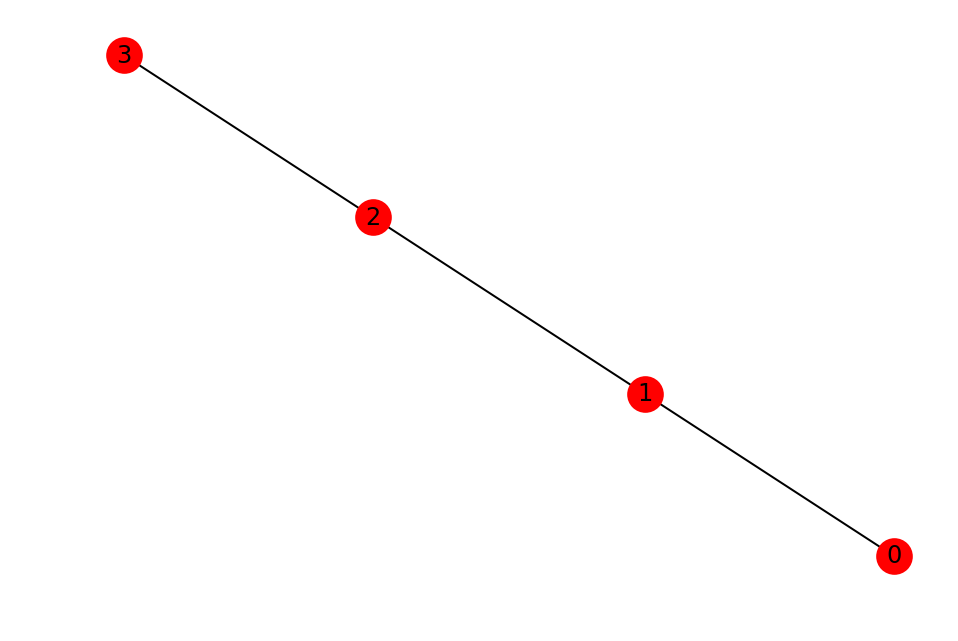

In [100]:
nx.draw(G1, with_labels=True)

## Matrix Form

When represented in matrix form, it looks like the plot below. (Explain row by columns = node by nodes.)

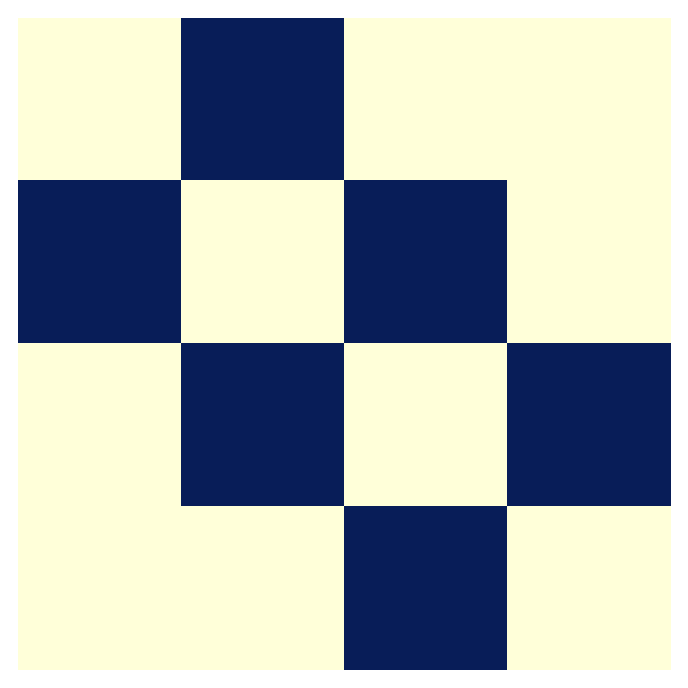

In [101]:
nv.MatrixPlot(G1).draw()

## Playing with the matrix form

NetworkX provides a `to_numpy_array()` function that will return a numpy array of the graph. That is used behind-the-scenes in `nxviz` to generate the MatrixPlot.

In [102]:
A1 = nx.to_numpy_array(G1, nodelist=sorted(G1.nodes()))
A1

array([[ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  0.]])

One neat result is that if we take the adjacency matrix, and matrix-matrix multiply it against itself ("matrix power 2"), we will get back a new matrix that has interesting properties.

In [103]:
import numpy as np

# One way of coding this up
np.linalg.matrix_power(A1, 2)

# Another equivalent way, that takes advantage of Python 3.5's matrix multiply operator
A1 @ A1

array([[ 1.,  0.,  1.,  0.],
       [ 0.,  2.,  0.,  1.],
       [ 1.,  0.,  2.,  0.],
       [ 0.,  1.,  0.,  1.]])

**Firstly**, if we look at the off-diagonals of the new matrix, this corresponds to the number of paths of length 2 that exist between those two nodes.

In [104]:
np.diag(A1 @ A1)

array([ 1.,  2.,  2.,  1.])

Here, one path of length 2 exists between node 0 and node 2, and one path of length 2 exists between node 1 and node 3.

**Secondly**, you may notice that the diagonals look like the degree of the nodes. This is a unique property of the 2nd adjacency matrix power: for every node, there are $ d $ degree paths of length two to get back to that same node.

Not convinced? To get from a node and back, that's a path length of 2! :-)

Let's see if the following statment is true: The $ k^{th} $ matrix power of the graph adjacency matrix indicates how many paths of length $ k $ exist between each pair of nodes.

In [105]:
np.linalg.matrix_power(A1, 3)

array([[ 0.,  2.,  0.,  1.],
       [ 2.,  0.,  3.,  0.],
       [ 0.,  3.,  0.,  2.],
       [ 1.,  0.,  2.,  0.]])

Indeed, if we think about it, there is, by definition, no way sequence of graph traversals that will allow us to go back to a node within 3 steps. We will always end up at some neighboring node.

In addition, to get to the neighboring node in 3 steps, there are two ways to go about it:

- node -> neighbor -> node -> neighbor
- node -> neighbor -> neighbor's neighbor -> neighbor

Or for the case of this chain graph:

- 0 -> 1 -> 0 -> 1
- 0 -> 1 -> 2 -> 1

# Toy Example: Directed Linear Chain

Let's see if the same properties hold for a directed graph.

In [57]:
nodes

[0, 1, 2, 3]

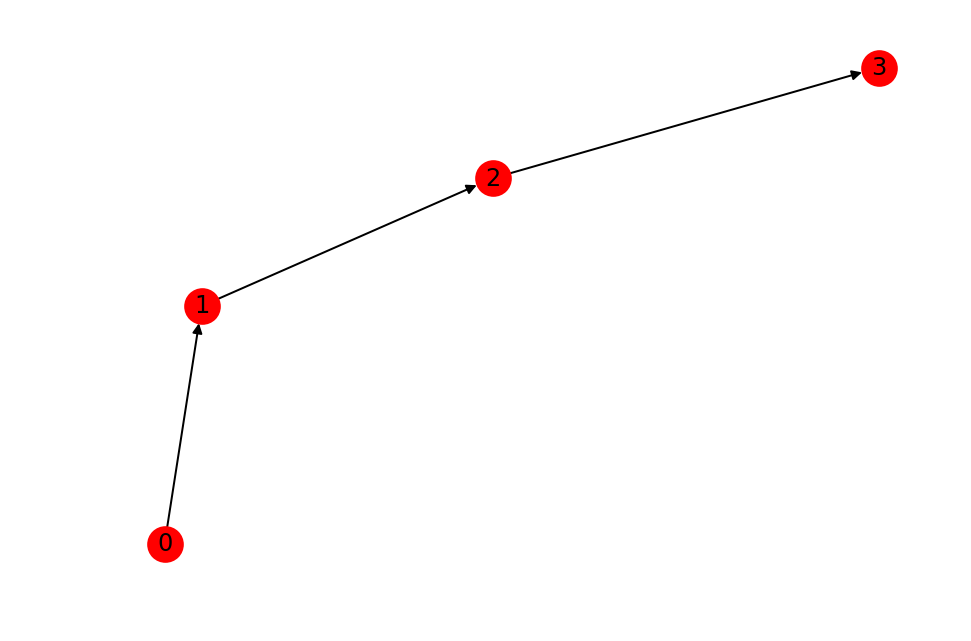

In [59]:
G2 = nx.DiGraph()
G2.add_nodes_from(nodes)
G2.add_edges_from(zip(nodes, nodes[1:]))
nx.draw(G2, with_labels=True)

Recall that in a directed graph, the matrix representation is not guaranteed to be symmetric.

In [61]:
A2 = nx.to_numpy_array(G2)
A2

array([[ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.]])

Let's look at the 2nd matrix power: the number of paths of length 2 between any pair of nodes.

In [65]:
np.linalg.matrix_power(A2, 2)

array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

We see that there's only one path from node 0 to node 2 of length 2, and one path from node 1 to node 3. If you're not convinced of this, trace it for yourself!

## Exercise

In this directed graph, how many paths are there from node 0 to node 3 of length 3? Compute the 3rd matrix power and verify your answer.

In [66]:
np.linalg.matrix_power(A2, 3)

array([[ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

# Real Data

Now that we've looked at a toy example, let's play around with a real dataset!

This dataset is a residence hall rating dataset. From the [source website](http://konect.uni-koblenz.de/networks/moreno_oz):

> This directed network contains friendship ratings between 217 residents living at a residence hall located on the Australian National University campus. A node represents a person and edges contain ratings of one friend to another.

For the purposes of this exercise, we will treat the edges as if they were unweighted.


In [89]:
G = load_university_social_network()

## Exercise

Use nxviz's MatrixPlot to draw the graph.

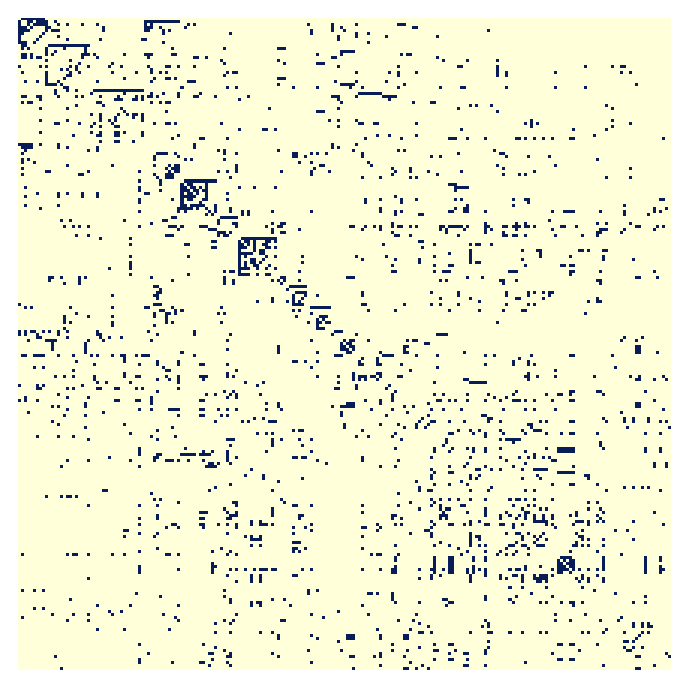

In [90]:
nv.MatrixPlot(G).draw()

## Exercise

Using what you know from the previous material, find out how many connected component subgraphs there are in the subgraph.

**Hint:** You may need to convert the graph to an undirected one first.

In [91]:
list(nx.connected_component_subgraphs(G.to_undirected()))

## Exercise

Since there is only one connected component subgraph, pick two nodes in the graph and see how many shortest paths there exist between those two nodes.

**Hint:** You will first need to know what the shortest path length is between those two nodes.

In [93]:
nx.shortest_path(G, 30, 100)

[30, 196, 115, 100]

In [98]:
A = nx.to_numpy_array(G)
np.linalg.matrix_power(A, 4)[29, 99]

40.0

# Message Passing

Message passing on graphs is a fascinating topic to explore. It's a neat way to think about a wide variety of problems, including the spread of infectious disease agents, rumours, and more. As it turns out, there's a direct matrix interpretation of the message passing operation.

To illustrate this more clearly, let's go back to the directed chain graph, `G2`.

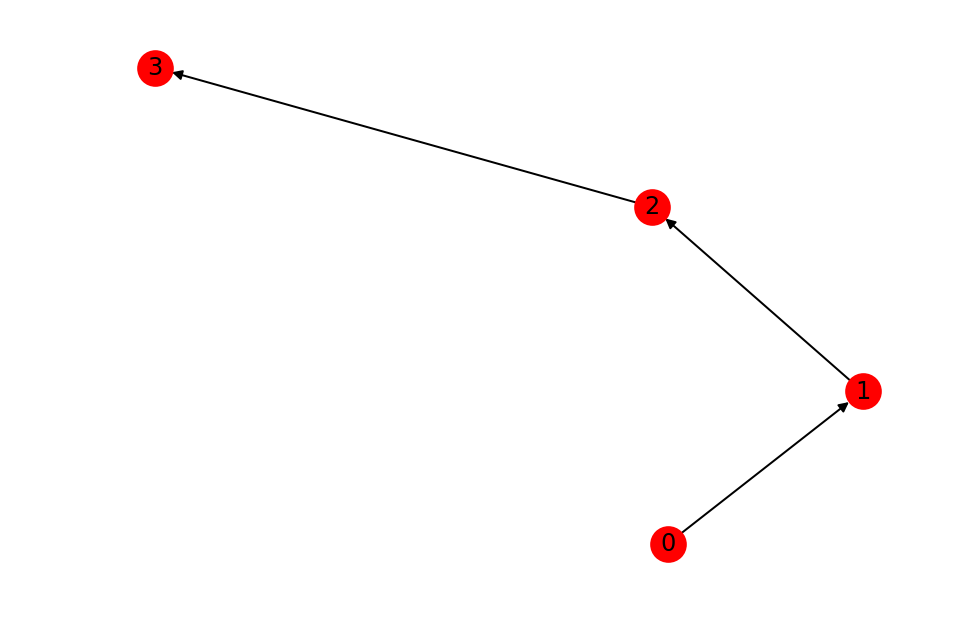

In [107]:
nx.draw(G2, with_labels=True)

If we have a message that begins at node 0, and it is only passed to its neighbors, then node 1 is the next one that possess the message. Node 1 then passes it to node 2, and so on, until it reaches node 3.

There are two key ideas to introduce here. Firstly, there is the notion of the **"wavefront"** of message passing: at the first time step, node 0 is the wavefront, and as time progresses, node 1, 2 and 3 progressively become the wavefront.

Secondly, as the message gets passed, the number of nodes that have seen the message progressively increases. 

Let's see how this gets implemented in matrix form.

## Matrix Message Passing

To represent the data, we start with a vertical array of messages of shape `(1, 4)`. Let's use the following conventions:

- `1` indicates that a node currently has the message.
- `0` indicates that a node currently does not have the message.

Since the message starts at node 0, let's put a `1` in that cell of the array, and `0`s elsewhere.

In [111]:
msg = np.array([1, 0, 0, 0]).reshape(1, 4)
msg

array([[1, 0, 0, 0]])

In order to simulate one round of message passing, we matrix multiply the message with the adjacency matrix.

In [113]:
msg2 = msg @ A2
msg2

array([[ 0.,  1.,  0.,  0.]])

The interpretation now is that the message is currently at node 1.

To simulate a second round, we take that result and matrix multiply it against the adjacency matrix again.

In [115]:
msg3 = msg2 @ A2
msg3

array([[ 0.,  0.,  1.,  0.]])

The interpretation now is that the message is currently at node 2.

Let's make an animation of this.

In [233]:
# fig, ax = plt.subplots()

def propagate(G, msg):
    """
    Computes the node values based on propagation.
    
    :msg: The initial state of the message.
    """
    node_colors = []
    new_msg = msg
    A = nx.to_numpy_array(G)
    for i in range(len(msg)):
        node_colors.append(new_msg)
        new_msg = new_msg @ A
    return node_colors

def update_func(step, nodes, colors):
    nodes.set_array(colors[step].ravel())
    return nodes

def anim(G, colors, n_frames=4):
    fig = plt.figure()
    pos = {i:(i, i) for i in range(len(G))}
    adj = nx.to_numpy_array(G)
    pos = nx.kamada_kawai_layout(G)
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors[0].ravel())
    ax = nx.draw_networkx_edges(G, pos)
    return animation.FuncAnimation(fig, update_func, frames=range(n_frames), fargs=(nodes, colors))


# HTML(anim(G2, propagate(msg)).to_html5_video())

In [232]:
msg = np.zeros(len(G))
msg[0] = 1
HTML(anim(G, propagate(G, msg))).to_html5_video()

TypeError: draw_networkx_nodes() missing 1 required positional argument: 'pos'

RuntimeError: The init_func must return a sequence of Artist objects.

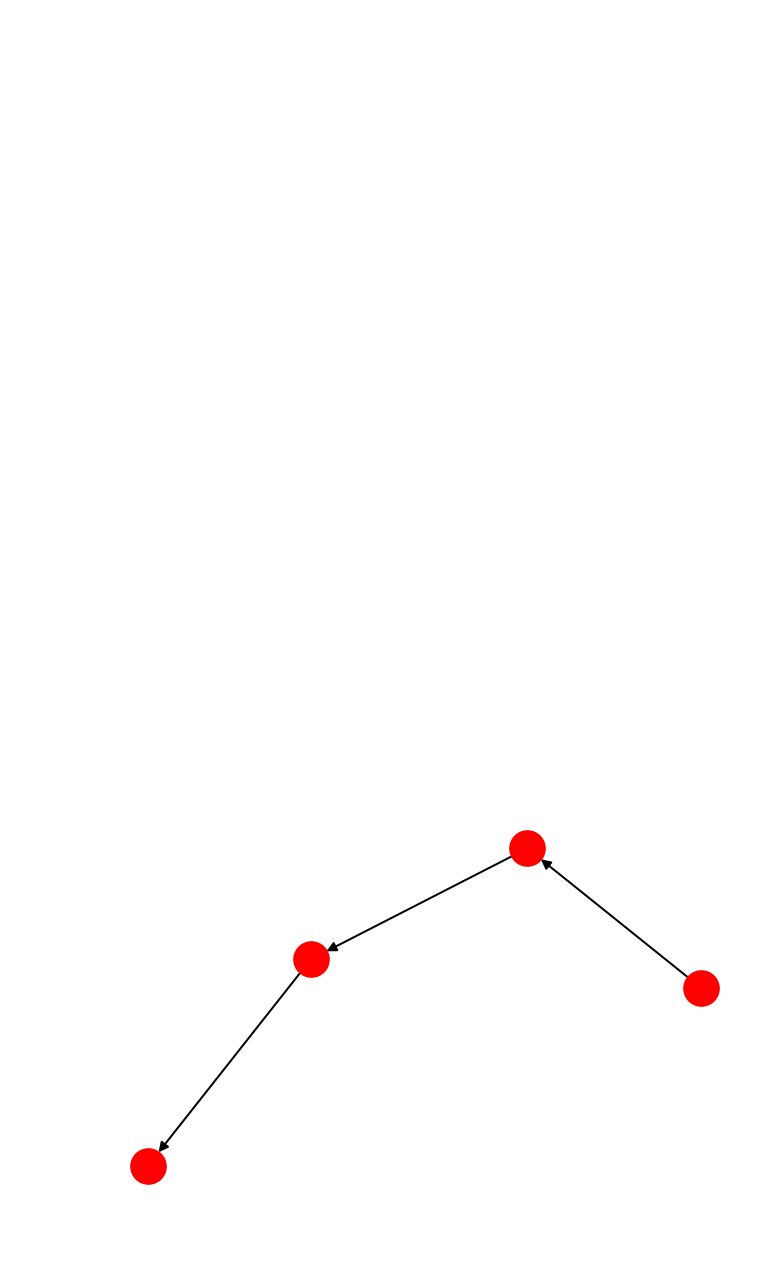

In [125]:
from matplotlib.animation import FuncAnimation

pos = {i:i for i in nodes}


def propagation_animation(inputs, G, data, n_frames):
    fig, ax = plt.subplots()
    nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=colors)

def init():
    nx.draw(G2)

def update(frame):
    return nx.draw(G2, ax=ax, node_color=node_colors[i])

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
HTML(ani.to_html5_video())
